### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm, PowerNorm, AsinhNorm
from matplotlib.ticker import MaxNLocator, LogLocator

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

from pathlib import Path

import pandas as pd

### Experiments data

In [4]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde']}

In [5]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8]}

In [6]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_6': [0.3865, 0.6135],
                                    'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3702, 0.6298]}

In [7]:
cwd = Path(os.getcwd())
path = cwd.parent.absolute()

In [8]:
experiments_folders = [name for name in os.listdir(path)
                    if os.path.isdir(os.path.join(path, name)) and str(name).startswith('experiment')]

### Improving heatmaps

In [9]:
experiments_folders

['experiment_1_intensity_difference',
 'experiment_8_different_solvents',
 'experiment_9_and_4_shim',
 'experiment_3_perfumes_and_absent_components',
 'experiment_5_metabolites',
 'experiment_2_overlapping',
 'experiment_7_overlapping_and_intensity_difference',
 'experiment_6_miniperfumes']

In [10]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping'}

In [11]:
nr_of_experiment = 9

In [12]:
list_of_results_for_experiments = []

for nr_of_experiment in range(1,10):
    
    #MOLAR
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
            list_of_dataframes_with_results = pickle.load(f)
    else:
        with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
            list_of_dataframes_with_results = pickle.load(f)
            
    molar_proportions = ground_truth_molar_proportions['experiment_'+str(nr_of_experiment)]
    protons = protons_dictionary['experiment_'+str(nr_of_experiment)]
    
    temp = []
    for nr_of_component, df in enumerate(list_of_dataframes_with_results):
        temp.append(df/protons[nr_of_component])
    temp2 = []
    for df in temp:
        temp2.append(df/sum(temp))
    list_of_dataframes_with_results = temp2
    del(temp)
    del(temp2)
    
    dataframes_ready_for_heatmap = []
    for i, df in enumerate(list_of_dataframes_with_results):
        preprocessed_df = abs(df - molar_proportions[i])
        dataframes_ready_for_heatmap.append(preprocessed_df)
        
    all_components_results_molar = sum(dataframes_ready_for_heatmap)
    list_of_results_for_experiments.append(all_components_results_molar)
    
    #VISIBLE
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
            list_of_dataframes_with_results = pickle.load(f)
    else:
        with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
            list_of_dataframes_with_results = pickle.load(f)
            
    real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
    real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]
    
    dataframes_ready_for_heatmap = []
    for i, df in enumerate(list_of_dataframes_with_results):
        preprocessed_df = abs(df - real_visible_proportions[i])
        dataframes_ready_for_heatmap.append(preprocessed_df)
        
    all_components_results_vis = sum(dataframes_ready_for_heatmap)
    #DELIBERATELY NOT SAVING VISIBLE PROPORTIONS, CAUSE WE ARE ONLY INTERESTED IN MOLAR
    #list_of_results_for_experiments.append(all_components_results_vis)

In [16]:
shapes_list = [l.shape for l in list_of_results_for_experiments]
min_shape = min([sh[0] for sh in shapes_list])

29

In [18]:
total_error_all_experiments = sum([df.iloc[:min_shape, :min_shape] for df in list_of_results_for_experiments])

In [19]:
all_components_results_both = total_error_all_experiments

In [20]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [21]:
all_components_results_both.min().min()

0.25617809206907616

In [28]:
all_components_results_both[0.22][0.25]

0.25617809206907616

In [ ]:
### DEFAULT: kappa_mixture = 0.25, kappa_components = 0.22

<IPython.core.display.Javascript object>


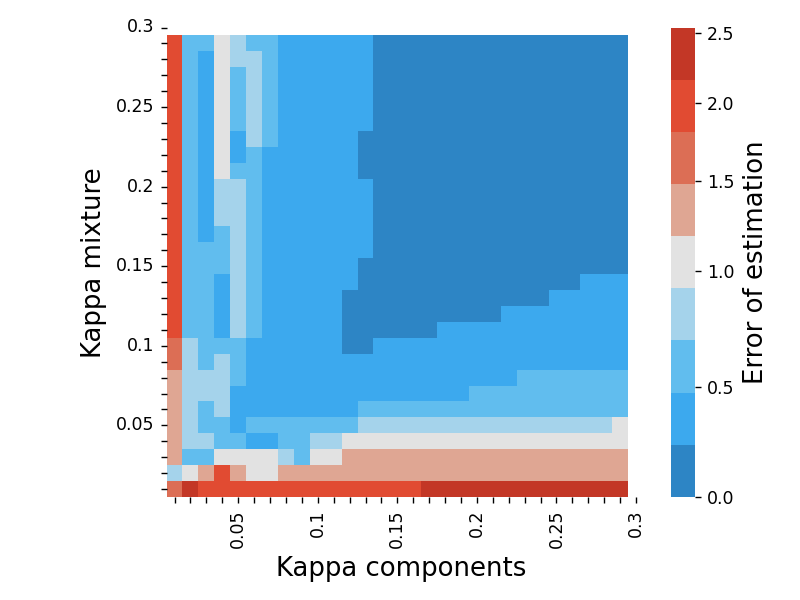

In [39]:
colors = ['#2D85C5', '#3CA9EE', '#61BDEE', '#A5D3EB',\
          '#E2E2E2', '#DFA693', '#DC6E55', '#E14B32', '#C33726']

vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

my_cmap = ListedColormap(colors)
my_norm = PowerNorm(0.65, vmin, vmax)


labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

ax = sns.heatmap(all_components_results_both.astype(float), yticklabels=labels, cbar=True,
                square=True, vmin=vmin, vmax=vmax, xticklabels = labels,
                cmap=my_cmap, norm=my_norm, cbar_ax=None)

ax.invert_yaxis()

for ind, label in enumerate(ax.get_xticklabels()):
    if (ind+1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
for ind, label in enumerate(ax.get_yticklabels()):
    if (ind+1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

cbar = ax.collections[0].colorbar
cbar.set_label('Error of estimation', fontsize=15, labelpad=5)
# minorticks = [0.1, 0.2]
# cbar.ax.yaxis.set_ticks(minorticks, minor=True)

plt.xlabel("Kappa components", fontsize=15, labelpad=5)
plt.ylabel("Kappa mixture", fontsize=15, labelpad=5)

plt.tight_layout()
plt.show()